In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_u(x, t):
    return torch.sin(x)*torch.cos(t)

def initial_condition_u(x):
    return torch.sin(x) 

In [3]:
# Define the exact solution p = E
def exact_solution_p(x, t):
    return -torch.sin(t)*torch.cos(x)

def initial_condition_p(x):
    return 0.0*torch.sin(x) 

In [4]:
# assigning number of points
initial_pts = 200
left_boundary_pts = 200 
right_boundary_pts = 200
residual_pts = 1000

In [5]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
w_init = torch.cat([u_init, p_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
p_b_l = exact_solution_p(xb_left, tb_left)
w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
p_b_r = exact_solution_p(xb_right, tb_right)
w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right), batch_size=200, shuffle=False)

In [6]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [7]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [8]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [9]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [10]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:,0].reshape(-1,1)
                p_hat = w_hat[:,1].reshape(-1,1)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
               
                
                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_x = grad_p_hat[:, 0].reshape(-1,1)
                
              
                
                
                
                #grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                #u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1,1)
                
               
                
                p_t = grad_p_hat[:,1].reshape(-1,1)
             
                
                
                
                # Item 1. below
                loss1 = torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + torch.mean((u_t.reshape(-1, ) + p_x.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((2*p_t.reshape(-1, )  + u_x.reshape(-1, ) + torch.cos(interior[:, 0])*torch.cos(interior[:, 1]))**p)+torch.mean((p_bd_left_pred_.reshape(-1,) - p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
                loss = loss1 + loss2
                #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
 
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [11]:
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  9.345173835754395
################################  1  ################################
Loss:  9.099297523498535
################################  2  ################################
Loss:  7.813823223114014
################################  3  ################################
Loss:  6.557641983032227
################################  4  ################################
Loss:  5.538811683654785
################################  5  ################################
Loss:  4.723112106323242
################################  6  ################################
Loss:  4.047317981719971
################################  7  ################################
Loss:  3.474017381668091
################################  8  ################################
Loss:  2.9868831634521484
################################  9  ################################
Loss:  2.578435182571411
################################  10  ###########

Loss:  0.009383441880345345
################################  86  ################################
Loss:  0.009024210274219513
################################  87  ################################
Loss:  0.00870080292224884
################################  88  ################################
Loss:  0.008394194766879082
################################  89  ################################
Loss:  0.008112089708447456
################################  90  ################################
Loss:  0.007827562279999256
################################  91  ################################
Loss:  0.0075629716739058495
################################  92  ################################
Loss:  0.00727993156760931
################################  93  ################################
Loss:  0.007034497335553169
################################  94  ################################
Loss:  0.006752306595444679
################################  95  ################################
Loss:  0.00

Loss:  0.0006959617603570223
################################  168  ################################
Loss:  0.0006791107589378953
################################  169  ################################
Loss:  0.0006640314823016524
################################  170  ################################
Loss:  0.0006467335042543709
################################  171  ################################
Loss:  0.000628963578492403
################################  172  ################################
Loss:  0.0006114462157711387
################################  173  ################################
Loss:  0.000594295677728951
################################  174  ################################
Loss:  0.0005779847269877791
################################  175  ################################
Loss:  0.0005623875767923892
################################  176  ################################
Loss:  0.0005473496858030558
################################  177  #########################

Loss:  0.00017129888874478638
################################  249  ################################
Loss:  0.00017009509610943496
################################  250  ################################
Loss:  0.00016885586956050247
################################  251  ################################
Loss:  0.00016761606093496084
################################  252  ################################
Loss:  0.00016637159569654614
################################  253  ################################
Loss:  0.00016510386194568127
################################  254  ################################
Loss:  0.0001638181711314246
################################  255  ################################
Loss:  0.00016252713976427913
################################  256  ################################
Loss:  0.00016120614600367844
################################  257  ################################
Loss:  0.0001599188835825771
################################  258  ###############

Loss:  7.892319263191894e-05
################################  334  ################################
Loss:  7.871940761106089e-05
################################  335  ################################
Loss:  7.851205009501427e-05
################################  336  ################################
Loss:  7.830169488443062e-05
################################  337  ################################
Loss:  7.809334056219086e-05
################################  338  ################################
Loss:  7.787921640556306e-05
################################  339  ################################
Loss:  7.766309136059135e-05
################################  340  ################################
Loss:  7.743708556517959e-05
################################  341  ################################
Loss:  7.72160419728607e-05
################################  342  ################################
Loss:  7.699723209952936e-05
################################  343  ########################

Loss:  5.424914706964046e-05
################################  416  ################################
Loss:  5.401419912232086e-05
################################  417  ################################
Loss:  5.377124762162566e-05
################################  418  ################################
Loss:  5.355665780371055e-05
################################  419  ################################
Loss:  5.332875662134029e-05
################################  420  ################################
Loss:  5.306424282025546e-05
################################  421  ################################
Loss:  5.2828152547590435e-05
################################  422  ################################
Loss:  5.2605992095777765e-05
################################  423  ################################
Loss:  5.238702578935772e-05
################################  424  ################################
Loss:  5.219707963988185e-05
################################  425  #####################

Loss:  3.758804814424366e-05
################################  499  ################################
Loss:  3.739854219020344e-05
################################  500  ################################
Loss:  3.723975532921031e-05
################################  501  ################################
Loss:  3.708938311319798e-05
################################  502  ################################
Loss:  3.694704355439171e-05
################################  503  ################################
Loss:  3.681352245621383e-05
################################  504  ################################
Loss:  3.669201396405697e-05
################################  505  ################################
Loss:  3.658479545265436e-05
################################  506  ################################
Loss:  3.647301491582766e-05
################################  507  ################################
Loss:  3.6382356483954936e-05
################################  508  ######################

Loss:  2.6830053684534505e-05
################################  592  ################################
Loss:  2.6752433768706396e-05
################################  593  ################################
Loss:  2.6681871531764045e-05
################################  594  ################################
Loss:  2.6611174689605832e-05
################################  595  ################################
Loss:  2.654125819390174e-05
################################  596  ################################
Loss:  2.6470303055248223e-05
################################  597  ################################
Loss:  2.639643025759142e-05
################################  598  ################################
Loss:  2.632772157085128e-05
################################  599  ################################
Loss:  2.626327841426246e-05
################################  600  ################################
Loss:  2.619661609060131e-05
################################  601  ##################

Loss:  2.19618268602062e-05
################################  673  ################################
Loss:  2.1909807401243597e-05
################################  674  ################################
Loss:  2.1857213141629472e-05
################################  675  ################################
Loss:  2.1802887204103172e-05
################################  676  ################################
Loss:  2.1742616809206083e-05
################################  677  ################################
Loss:  2.1686120817321353e-05
################################  678  ################################
Loss:  2.1626030502375215e-05
################################  679  ################################
Loss:  2.1565374481724575e-05
################################  680  ################################
Loss:  2.1502157323993742e-05
################################  681  ################################
Loss:  2.1433868823805824e-05
################################  682  ###############

Loss:  1.675345265539363e-05
################################  755  ################################
Loss:  1.6700148989912122e-05
################################  756  ################################
Loss:  1.6651574696879834e-05
################################  757  ################################
Loss:  1.6614716514595784e-05
################################  758  ################################
Loss:  1.6581714589847252e-05
################################  759  ################################
Loss:  1.6549911379115656e-05
################################  760  ################################
Loss:  1.6518590200576e-05
################################  761  ################################
Loss:  1.6487982065882534e-05
################################  762  ################################
Loss:  1.646040254854597e-05
################################  763  ################################
Loss:  1.64350240083877e-05
################################  764  ####################

Loss:  1.3001311344851274e-05
################################  845  ################################
Loss:  1.2970086572750006e-05
################################  846  ################################
Loss:  1.294807134399889e-05
################################  847  ################################
Loss:  1.2924977454531472e-05
################################  848  ################################
Loss:  1.2900032743345946e-05
################################  849  ################################
Loss:  1.2872594197688159e-05
################################  850  ################################
Loss:  1.284541122004157e-05
################################  851  ################################
Loss:  1.2818707546102814e-05
################################  852  ################################
Loss:  1.2793464520655107e-05
################################  853  ################################
Loss:  1.2768279702868313e-05
################################  854  ###############

Loss:  1.1038460797863081e-05
################################  928  ################################
Loss:  1.1018444638466462e-05
################################  929  ################################
Loss:  1.0998705874953885e-05
################################  930  ################################
Loss:  1.0979123544530012e-05
################################  931  ################################
Loss:  1.0960315194097348e-05
################################  932  ################################
Loss:  1.0941329492197838e-05
################################  933  ################################
Loss:  1.0921663488261402e-05
################################  934  ################################
Loss:  1.0900595952989534e-05
################################  935  ################################
Loss:  1.0879361980187241e-05
################################  936  ################################
Loss:  1.085777512344066e-05
################################  937  ##############

Loss:  8.886037903721444e-06
################################  1009  ################################
Loss:  8.85890403878875e-06
################################  1010  ################################
Loss:  8.831254490360152e-06
################################  1011  ################################
Loss:  8.806175173958763e-06
################################  1012  ################################
Loss:  8.782127224549185e-06
################################  1013  ################################
Loss:  8.760602213442326e-06
################################  1014  ################################
Loss:  8.73953104019165e-06
################################  1015  ################################
Loss:  8.719930519873742e-06
################################  1016  ################################
Loss:  8.699562386027537e-06
################################  1017  ################################
Loss:  8.680215614731424e-06
################################  1018  ###############

Loss:  7.264523446792737e-06
################################  1100  ################################
Loss:  7.2558286774437875e-06
################################  1101  ################################
Loss:  7.2470888881071005e-06
################################  1102  ################################
Loss:  7.237917998281773e-06
################################  1103  ################################
Loss:  7.228112281154608e-06
################################  1104  ################################
Loss:  7.217656275315676e-06
################################  1105  ################################
Loss:  7.206429472716991e-06
################################  1106  ################################
Loss:  7.195087164291181e-06
################################  1107  ################################
Loss:  7.183470188465435e-06
################################  1108  ################################
Loss:  7.171562174335122e-06
################################  1109  ###########

Loss:  6.115295036579482e-06
################################  1193  ################################
Loss:  6.108636625867803e-06
################################  1194  ################################
Loss:  6.102769020799315e-06
################################  1195  ################################
Loss:  6.097270670579746e-06
################################  1196  ################################
Loss:  6.092205694585573e-06
################################  1197  ################################
Loss:  6.087444489821792e-06
################################  1198  ################################
Loss:  6.082856089051347e-06
################################  1199  ################################
Loss:  6.078411843191134e-06
################################  1200  ################################
Loss:  6.073873009881936e-06
################################  1201  ################################
Loss:  6.069531082175672e-06
################################  1202  #############

Loss:  5.0226872190251015e-06
################################  1286  ################################
Loss:  5.008626430935692e-06
################################  1287  ################################
Loss:  4.995853942091344e-06
################################  1288  ################################
Loss:  4.983698090654798e-06
################################  1289  ################################
Loss:  4.9726286306395195e-06
################################  1290  ################################
Loss:  4.9615259740676265e-06
################################  1291  ################################
Loss:  4.949142748955637e-06
################################  1292  ################################
Loss:  4.938063284498639e-06
################################  1293  ################################
Loss:  4.92847084387904e-06
################################  1294  ################################
Loss:  4.919737421005266e-06
################################  1295  ###########

Loss:  4.3899071897612885e-06
################################  1371  ################################
Loss:  4.383725809020689e-06
################################  1372  ################################
Loss:  4.377520326670492e-06
################################  1373  ################################
Loss:  4.371830527816201e-06
################################  1374  ################################
Loss:  4.3669087972375564e-06
################################  1375  ################################
Loss:  4.362493200460449e-06
################################  1376  ################################
Loss:  4.358611931820633e-06
################################  1377  ################################
Loss:  4.355037617642665e-06
################################  1378  ################################
Loss:  4.35157744504977e-06
################################  1379  ################################
Loss:  4.348260063125053e-06
################################  1380  ############

Loss:  4.012756107840687e-06
################################  1455  ################################
Loss:  4.005111350124935e-06
################################  1456  ################################
Loss:  3.998200554633513e-06
################################  1457  ################################
Loss:  3.99158670916222e-06
################################  1458  ################################
Loss:  3.984407157986425e-06
################################  1459  ################################
Loss:  3.978573204221902e-06
################################  1460  ################################
Loss:  3.972693775722291e-06
################################  1461  ################################
Loss:  3.967571501561906e-06
################################  1462  ################################
Loss:  3.961785751016578e-06
################################  1463  ################################
Loss:  3.95604638470104e-06
################################  1464  ###############

In [12]:
# saving and loading Model
#FILE = "maxwell1D_1.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [13]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [14]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

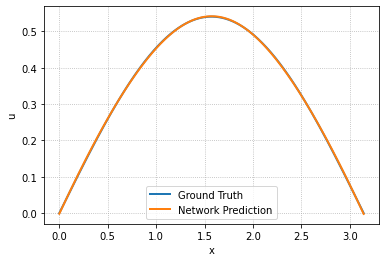

In [15]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [16]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0008444895684078801 %


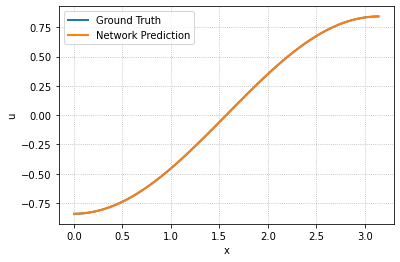

In [17]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [18]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  7.253348712765728e-05 %


In [19]:
# for ploting

In [20]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

In [21]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

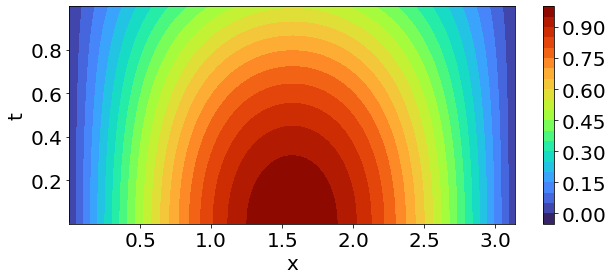

In [22]:

plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

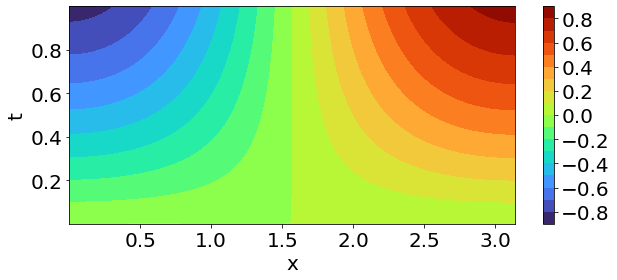

In [23]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

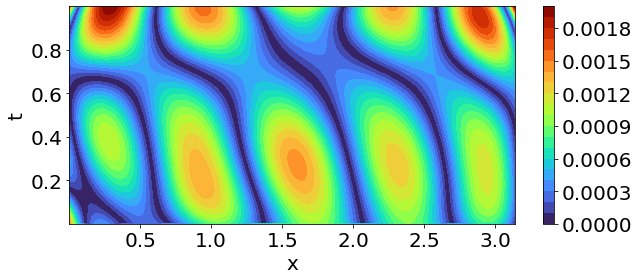

In [24]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

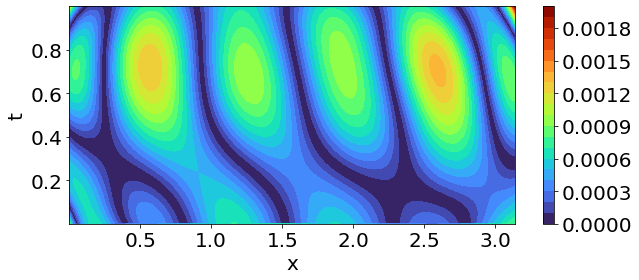

In [25]:



relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")